## Lab #1 - Object Detection

In this lab, we will run an object detection example on frames extracted from videos. For this purpose we will:
- Create a video object detection labeling job with Amazon SageMaker GroundTruth
- Train an object detection model on the labeled data with an Amazon SageMaker estimator, applying transfer learning with a pre-trained model from a model zoo
- Deploy the trained model to an Amazon SageMaker endpoint for performing some real-time inferences with sample frames
- Perform an Amazon SageMaker transformation for running batch inferences over a group of stored frames

## Setup

In [29]:
#!pip install opencv-python

#### Libraries

In [63]:
import sagemaker
from sagemaker.mxnet import MXNet
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import json
import cv2
import os
import boto3
import ast

#### Variables

In [64]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'rodzanto2020ml'
#bucket = sagemaker_session.default_bucket()
task = 'football2-60-od-images'
images_prefix = 'sports/football2_in/Football2.mp4'
label_prefix = 'sports/football2_in/football2-60-od-images/{}'.format(task)
classes = ['ball', 'midfield', 'goal', 'cristiano']
inf_prefix = 'sports/football2_in/validation_sample'

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',images_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)

Execution_role: arn:aws:iam::889960878219:role/service-role/AmazonSageMaker-ExecutionRole-20180920T165537
S3_bucket: rodzanto2020ml
Ground-truth_labeling task: football2-60-od-images
S3_images_prefix: sports/football2_in/Football2.mp4
S3_label_prefix: sports/football2_in/football2-60-od-images/football2-60-od-images
Labeling_classes: ['ball', 'midfield', 'goal', 'cristiano']
S3_inference_prefix: sports/football2_in/validation_sample


## Labeling

Create a labeling job using SageMaker Ground Truth for a sample video. For simplicity, we will configure it such that it will extract an image every 60 frames and only consider 4 classes.

In [1]:
#TO BE DONE...


#### Inspect labels

The "manifest file" was created after completing the labeling job using SageMaker Ground Truth. It contains metadata about the images and the associated labels.

In [32]:
# Download output.manifest from the S3 bucket to the local notebook, if it doesn't exist locally already
if not os.path.isfile('output.manifest'):
    import boto3
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file('{}/manifests/output/output.manifest'.format(label_prefix), 'output.manifest')    

On each image, there are one or more objects. We can read this information from the `output.manifest` file.

In [33]:
image_info = []
with open('output.manifest') as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))
        
info = image_info[0]
print("Total number of images: {}".format(len(image_info)))
print("Ground Truth labeling for sample image:")
info

Total number of images: 187
Ground Truth labeling for sample image:


{'source-ref': 's3://rodzanto2020ml/sports/football2_in/Football2.mp4/frame_0000.jpeg',
 'football2-60-od-images': {'image_size': [{'width': 640,
    'height': 360,
    'depth': 3}],
  'annotations': [{'class_id': 0,
    'top': 200,
    'left': 476,
    'height': 14,
    'width': 12},
   {'class_id': 3, 'top': 165, 'left': 589, 'height': 46, 'width': 24},
   {'class_id': 1, 'top': 148, 'left': 76, 'height': 63, 'width': 316}]},
 'football2-60-od-images-metadata': {'objects': [{'confidence': 0},
   {'confidence': 0},
   {'confidence': 0}],
  'class-map': {'0': 'ball', '3': 'cristiano', '1': 'midfield'},
  'type': 'groundtruth/object-detection',
  'human-annotated': 'yes',
  'creation-date': '2021-02-03T17:44:25.264163',
  'job-name': 'labeling-job/football2-60-od-images'}}

Let's plot some of the labels, remember this is the result of the annotation done using SageMaker Ground Truth:

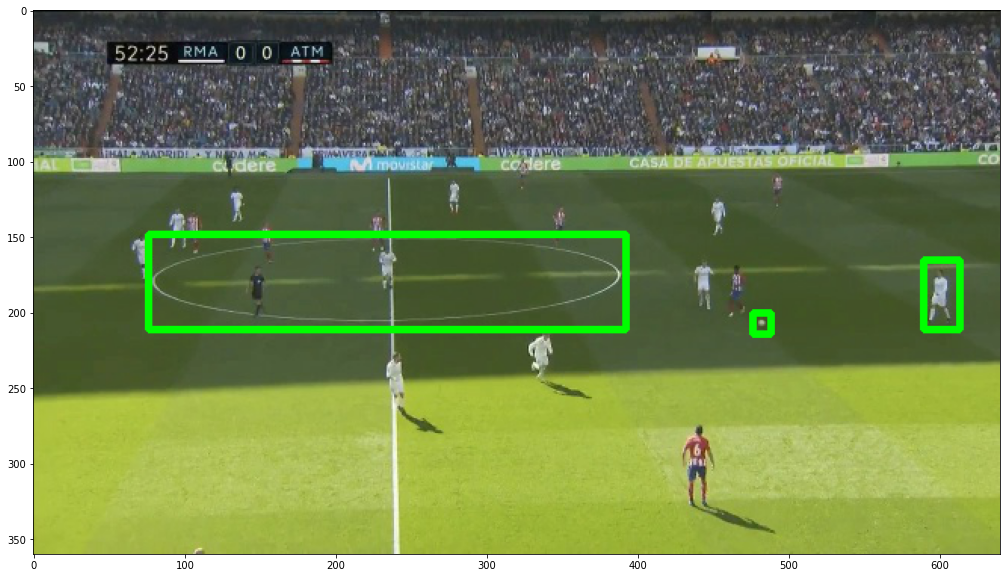

In [34]:
class_map = info[task+'-metadata']['class-map']
#image = plt.imread(os.path.join("sample_images",info['source-ref'].split('/')[-1]))
image = plt.imread('../sample_media/frame_0000.jpeg')
boxes = info[task]['annotations']

plt.figure(figsize = (20,10))
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

## Training using transfer learning

We will use the weights from a pre-trained MobileNet SSD neural network to detect our objects. MobileNets are lightweight networks for computer vision applications. The training will remove the last layer from the pre-trained network and replace it with a new output layer that predicts our labels.

The model will be taken from the MXNet GluonCV model-zoo: https://cv.gluon.ai/api/model_zoo.html#mobilenet

We will create an estimator with the Amazon SageMaker Python SDK, pointing to our training script located at: `entry_point/gluoncv_detection_ssd.py`.

In [46]:
mxnet_estimator = MXNet(entry_point = 'gluoncv_detection_ssd.py',
                        source_dir = 'entry_point',
                        role = role,
                        instance_type = 'ml.p3.2xlarge',
                        instance_count = 1,
                        framework_version = '1.8.0',
                        container_log_level = 40,
                        py_version = 'py37',
                        hyperparameters={'gt_labeling_task': task,
                                         'base_network': 'ssd_512_mobilenet1.0_custom',
                                         'classes': classes,
                                         'epochs': 20,
                                         'learning_rate': 0.001,
                                         'wd': 0.0005})

#### Fit model

In [47]:
s3_train_data = 's3://{}/{}'.format(bucket, images_prefix)
s3_label_data = 's3://{}/{}/manifests/output/'.format(bucket, prefix)

mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data})

2021-02-04 10:39:59 Starting - Starting the training job...
2021-02-04 10:40:23 Starting - Launching requested ML instancesProfilerReport-1612435199: InProgress
......
2021-02-04 10:41:29 Starting - Preparing the instances for training.........
2021-02-04 10:42:54 Downloading - Downloading input data
2021-02-04 10:42:54 Training - Downloading the training image.........
2021-02-04 10:44:30 Training - Training image download completed. Training in progress..Requirement already satisfied: Pillow in /usr/local/lib/python3.7/site-packages (from -r requirements.txt (line 1)) (8.0.1)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


*- Note: This step takes around 10 minutes to complete. -*

## Deployment and inference

#### Real-time inference

Here we deploy our model as a SageMaker endpoint for generating predictions on new sample images.

In [48]:
predictor = mxnet_estimator.deploy(
            instance_type='ml.m5.xlarge', 
            initial_instance_count=1,
            endpoint_name=task
)

-----------!

*- Note: This step takes around 6-7 minutes to complete. -*

We have now deployed our GluonCV object detection model in SageMaker, let's retrieve this endpoint.

In [49]:
%matplotlib inline

runtime = boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

for endpoint in  client.list_endpoints()['Endpoints']:
    if endpoint["EndpointName"] == task:
        gluoncv_endpoint = endpoint

gluoncv_endpoint

{'EndpointName': 'football2-60-od-images',
 'EndpointArn': 'arn:aws:sagemaker:eu-west-1:889960878219:endpoint/football2-60-od-images',
 'CreationTime': datetime.datetime(2021, 2, 4, 10, 49, 36, 266000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 2, 4, 10, 54, 54, 355000, tzinfo=tzlocal()),
 'EndpointStatus': 'InService'}

Finally, let's load some sample images and pass them to the endpoint. Sample images are available in `sample_media/`.

Sample images found: ['../sample_media/frame_0167.jpeg', '../sample_media/RMA_BAR_2017_0002.jpeg', '../sample_media/frame_0000.jpeg', '../sample_media/RMA_BAR_2017_0001.jpeg', '../sample_media/frame_0092.jpeg', '../sample_media/frame_0096.jpeg', '../sample_media/frame_0063.jpeg', '../sample_media/frame_0117.jpeg']
Running inference on 8 images.


<Figure size 1440x360 with 0 Axes>

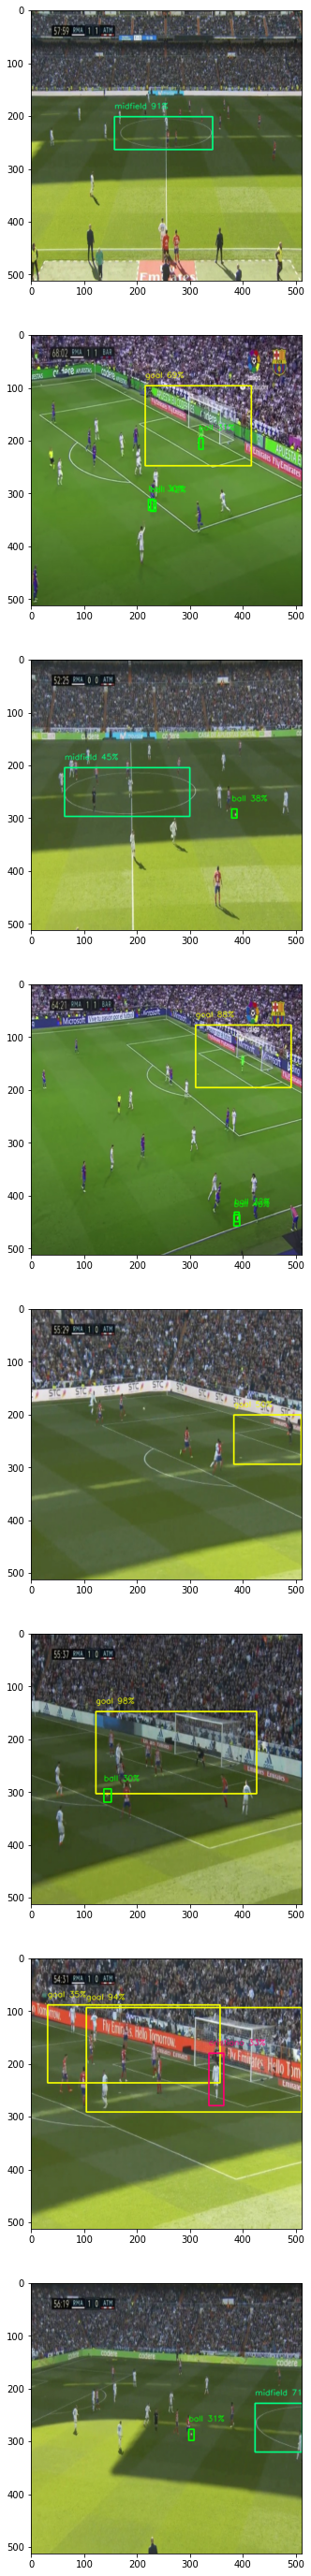

In [50]:
eval_images = glob.glob("../sample_media/*.jpeg")
print('Sample images found:',eval_images)
n_images = len(eval_images)
cols = (int(math.sqrt(n_images)))*2

fig = plt.figure(figsize = (20,5))
imgs = []
for n, (image) in enumerate(eval_images[:n_images]):
    orig_img = cv2.imread(image)
    orig_img = cv2.resize(orig_img, (512,512))
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    payload = json.dumps(img.tolist())
    response = runtime.invoke_endpoint(EndpointName = gluoncv_endpoint['EndpointName'],
                                       Body = payload)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
   
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], class_IDs[0], 
                                thresh=0.3, class_names = ["ball", "midfield", "goal", "cristiano"], colors = {0: (0, 255, 0)})
    imgs.append(orig_img)   

print('Running inference on',len(imgs),'images.')
fig = plt.figure(figsize = (50, 50))
columns = 1
rows = len(imgs)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB))
plt.show()

(Optional) Remember to delete the SageMaker endpoint after you are done with the testing inferences, for avoiding unnecessary costs.

In [70]:
print("Endpoint name: " + predictor.endpoint)
predictor.delete_endpoint()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: football2-60-od-images


#### Batch inference

You can also run predictions for batches of images stored in Amazon S3 through SageMaker Batch Transformations.

In [73]:
transformer = mxnet_estimator.transformer(instance_count=1,
                                          instance_type='ml.m5.xlarge')

In [74]:
transformer.transform('s3://{}/{}'.format(bucket, inf_prefix), content_type='application/x-image')
transformer.wait()

...............................2021-02-04T12:51:28.487:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
2021-02-04 12:51:27,814 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.7/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 2757 M
Python executable: /usr/local/bin/python3.7
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
2021-02-04 12:51:27,814 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.7/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 2757 M
Python ex

UnexpectedStatusException: Error for Transform job mxnet-training-2021-02-04-12-46-27-302: Failed. Reason: AlgorithmError: See job logs for more information

*- Note: This step takes around 10 minutes to complete. -*

Download the results for the batch transform.

In [ ]:
print(transformer.output_path)

In [ ]:
def predicted_label(transform_output):
    output = ast.literal_eval(transform_output)
    probabilities = output[0]
    return probabilities.index(max(probabilities))

Let's compare the first 10 images for illustration purposes.

In [ ]:
from sagemaker.s3 import S3Downloader

predictions = []
for i in range(3):
    file_key = '{}/data-{}.csv.out'.format(transformer.output_path, i)
    output = S3Downloader.read_file(file_key)

    predictions.append(predicted_label(output))

In [ ]:
plt.rcParams['figure.figsize'] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _,(subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

for i in range(10):
    input_file_name = 'data-{}.csv'.format(i)
    input_file_uri = 's3://{}/{}/{}'.format(sample_data_bucket, input_file_path, input_file_name)

    input_data = np.fromstring(S3Downloader.read_file(input_file_uri), sep=',')
    show_digit(input_data)

In [ ]:
print(predictions)